# Deep Learning for Chess

### 1. Project Topic

The goal of this project was to build a chess engine based purely on Deep Learning, without relying on traditional search algorithms (like Minimax or Monte Carlo Tree Search). This is a challenging and non-trivial task in the world of chess programming, since all known chess engines, including the top ones like AlphaZero or Stockfish, are heavily dependent on search, even if they use Deep Learning for position evaluations. By "search" I mean exploring huge number of variations of move sequences, sometimes with depth of 20, 30 or more. Instead of using search, my chess engine plays by choosing a best move according to numerical evaluation of all legal moves in a position, without considering next moves. So basically it's a search depth of 1.

The central part of my chess engine is the Deep Learning model and it is the main focus in this Jupyter Notebook. I trained the model on large dataset of chess positions, and it learned to predict an evaluation of a position. This is a regression task, since the output is a continuous value. In addition, my model also needed to recognize checkmate positions and evaluate them accordingly. The checkmates evaluation was a challenging part and I addressed it separately. Another challenge was to ensure the model was not only performing well on a validation set, but could actually play decent chess. These are not the same thing, and I had to solve this with unique approach to data augmentation and a few other optimizations.

Chess is a complex game with many rules, and if you've ever played a game or two, you know that it is not easy to learn the rules, and much harder to learn how to actually win. Luckily, I didn't need to implement the chess rules for my engine. I used the python-chess library for that, which handled all rules enforcement, legal moves generation, board representation and etc. So my model didn't have to learn the rules of chess, but to learn how to win the game.

In the following sections I will describe the data I used, the EDA, the architecture of my model, and will discuss the results and conclusions.

### 2. Data

My initial data comes from Kaggle: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations. It includes 3 files with evaluations data

* chessData.csv 
* random_evals.csv
* tactic_evals.csv

All these datasets have similar structure with two columns: the position and evaluation. The position is represented in a FEN notaion, a short format to describe the position of all pieces on a chess board. The evaluation can be of two types: a score, or moves-to-mate.

Those evaluations were generated by Stockfish chess engine, the strongest chess engine in the world. The 11th version of Stockfish, which was used for those evaluaions, was released in 2020. It was using a hand-crafted algorithm for calculating evaluations. A year later the evaluation algorithm was replaced by a deep learning approach (the NNUE architecture), but for my purposes the 11th version is more than enough - it has an ELO rating of 3400+, which is far beyond Grandmasters' levels.

The total amount of evaluation in those 3 files are 16 millions, but I will only use the random_eval.csv evaluations for my initial model, as it seemed to give the best results. Here are the dataset details:

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('positions/random_evals.csv')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000273 entries, 0 to 1000272
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   FEN         1000273 non-null  object
 1   Evaluation  1000273 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


And here are some samples of evaluations:

In [2]:
pd.set_option('display.max_colwidth', None)

df.head(10)

,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1NR b KQkq - 2 2,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK1NR b KQkq - 2 2,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB1R b KQkq - 2 2,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2,+209
5,rnbqkb1r/pppppppp/5n2/8/2B1P3/8/PPPP1PPP/RNBQK1NR b KQkq - 2 2,-101
6,rnbqkb1r/pppppppp/5n2/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 2 2,-105
7,rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPPNPPP/RNBQKB1R b KQkq - 2 2,-136
8,rnbqkb1r/pppppppp/5n2/7Q/4P3/8/PPPP1PPP/RNB1KBNR b KQkq - 2 2,-1262
9,rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPPBPPP/RNBQK1NR b KQkq - 2 2,-117


The FEN notation is using letters and numbers to represend board configuration. The "/" symbol divides the ranks of the board (horizontal rows). The letters represent piece type (r - Rook, n - Knight, b - Bishop, k - King, p - Pawn, q - Queen). Uppercase letter are for white pices and lowercase are for black. Numbers represents amount of empty consequtive squares. After the 8 ranks there is a 'w' or 'b' letter indicating the side to move in a position and final KQkq letters indicating the avalable castling options.

The evaluation is usually an integer number representing the numerical score of a position. Negative evaluation means the position is in favour of Black, positive - in favour of White. The value is based on centi-pawn difference, which is approximately 100 units for a Pawn, 300 for a Knight or a Bishop, 5 for a Rook and 9 for a Queen. The score can also be affected by other factors, like threats, checks, defence, and many other tactical or strategical factors.

Another type of the evaluation is "moves-to-mate". It takes a form of '#' sign and a number, for example '#+2' means white can checkmate in two moves, '#-1' means black can checkmate in 1 move. '#+0' means white won by a check mate '#-0' means black won by a checkmate.

### 3. Exploratory Data Analysis (EDA)

In this section I will explore and analyse the data. I will start by a simple example for a randomly selected evaluation record:


**4r1k1/1p1r2bp/pq4p1/8/4pPN1/1P1pQ2R/P1P3PP/4R1K1 w - - 2 30,+794**


I will use chess.com website to generate board state images and visualize FEN notations. The above FEN represents the following position:

![](board1.png)

The evaluation is +794 in favour of White. This totally makes sense as White has a really strong move (I'll leave it for you to discover)

Another example is for moves-to-mate score:

**2r2rk1/pp3p1p/2p1p1P1/5q2/6Q1/2P3R1/5PP1/4R1K1 w - - 1 23,#+2**

![](board2.png)

It's White turn to move, and it is mate in two moves.

Now that it's clear how FEN notation works, and what the evaluations mean, I will perform some general visualizations, which will help me understand the contents of the dataset. I'll begin with some statistics:

In [4]:
# max, min and mean scores
data = df.to_numpy()
data_scores = data[~np.char.startswith(data[:, 1].astype(str), '#')]
data_mtm = data[np.char.startswith(data[:, 1].astype(str), '#')]

print(f'Max score: {np.max(data_scores[:, 1].astype(int))}')
print(f'Min score: {np.min(data_scores[:, 1].astype(int))}')
print(f'Mean score: {np.mean(data_scores[:, 1].astype(int))}')

print()

mtm_values = np.array([int(x[1:]) for x in data_mtm[:, 1]])
print(f'Max moves to mate: {np.max(mtm_values)}')
print(f'Min moves to mate: {np.min(mtm_values)}')
print(f'Mean moves to mate: {np.mean(mtm_values)}')

Max score: 14489
Min score: -15265
Mean score: 10.2501035477416

Max moves to mate: 43
Min moves to mate: -54
Mean moves to mate: 0.381273994028153


Now that I know the range for both types of evaluation, I will visualize their distributions.

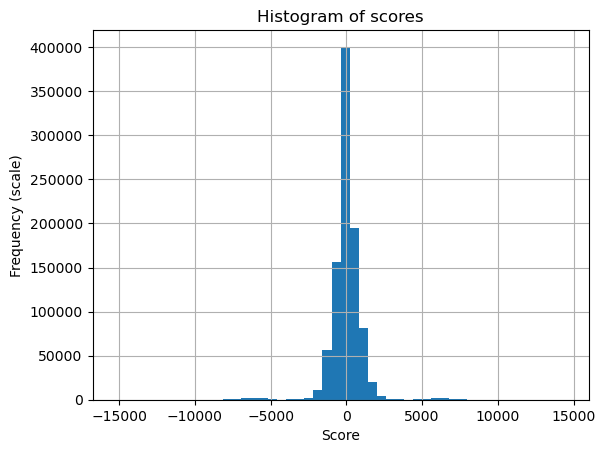

In [5]:
import matplotlib.pyplot as plt

plt.hist(data_scores[:, 1].astype(int), bins=50)
plt.title('Histogram of scores')
plt.xlabel('Score')
plt.ylabel('Frequency (scale)')
plt.grid(True)
plt.show()

Most of the evaluations are in the range of -2000 to +2000, with a huge spike around 0. This makes sense, as when the game begins the scores of the initial positions are around zero. Then in the middle of the game the score can start to deviate. When the score reaches the value of +-500 or +-1000, this indicates a big advantage for one of the sides. The symmetry of the data suggests a good variety of positions, with both Black and White advantages. To make it more clear, I'll show this histogram in log scale:

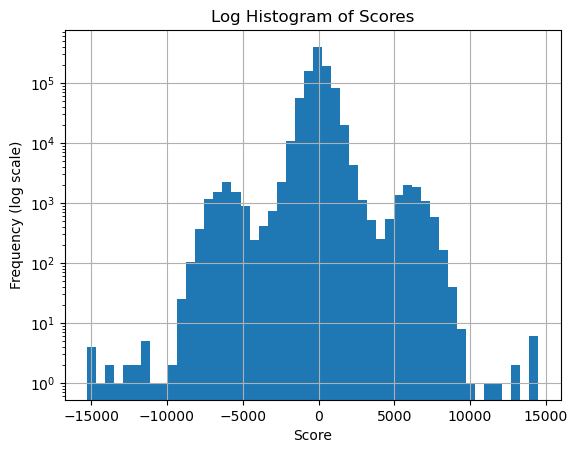

In [6]:
plt.hist(data_scores[:, 1].astype(int), bins=50, log=True)
plt.title('Log Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

The log scale shows that there is a big amount of scores in a wider range, between -10000 and 10000. This can indicate a presence of end-game positions, where one side has a big advantage. The symmetry is preserved on a log scale.

I will also check the histogram of moves-to-mate evaluations:

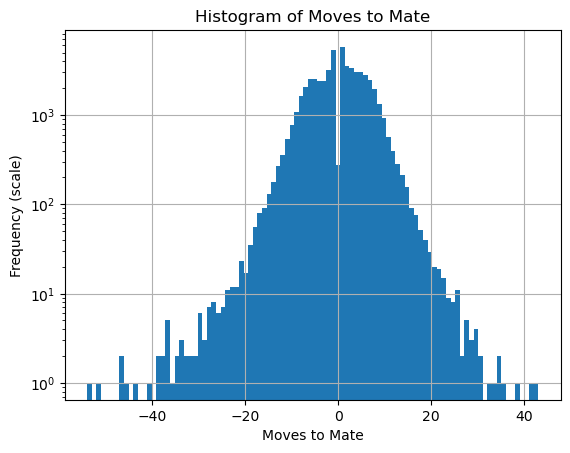

In [11]:
plt.hist(mtm_values, bins=98, range=(-54, 43), log=True)
plt.title('Histogram of Moves to Mate')
plt.xlabel('Moves to Mate')
plt.ylabel('Frequency (scale)')
plt.grid(True)
plt.show()

The above histogram shows a wide variety of moves-to-mate positions. But it doesn't have much checkmate positions (#+0 and #-0): less than 300 positions, which is not much for training. For the checkmates model I will the second dataset, tacic_evals.csv. And here is the distribution (more than 150k checkmate positions):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628219 entries, 0 to 2628218
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   FEN         object
 1   Evaluation  object
 2   Move        object
dtypes: object(3)
memory usage: 60.2+ MB


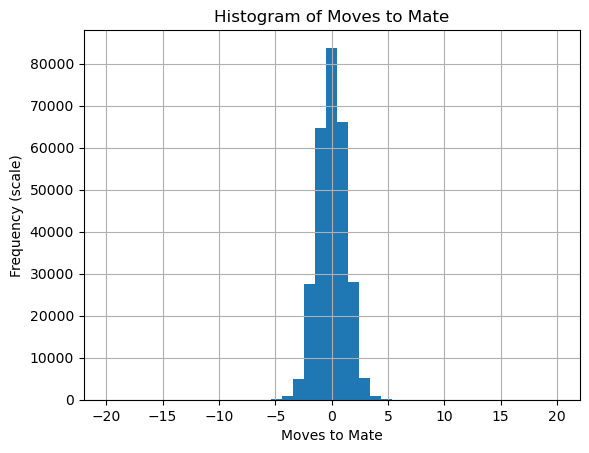

In [17]:
df = pd.read_csv('positions/tactic_evals.csv')
df.info()
data_mtm = df.to_numpy()
data_mtm = data_mtm[np.char.startswith(data_mtm[:, 1].astype(str), '#')]

mtm_values = np.array([int(x[1:]) for x in data_mtm[:, 1]])

plt.hist(mtm_values, bins=41, range=(-20, 20))
plt.title('Histogram of Moves to Mate')
plt.xlabel('Moves to Mate')
plt.ylabel('Frequency (scale)')
plt.grid(True)
plt.show()

In addition to those visualizations I checked a few randomly selected positions and evaluated them on chess.com website. The scores I got were very close to ones in the dataset, so I assume I can trust the data.

### 4. Model and Architecture

#### 4.1 Input encoding

Before building the model I had to decide about the input encoding, which will be suitable for a neural network. Obviously I couldn't use the FEN string as is, and I decided to transform the FENs into 8x8x17 tensors. Each 3D tensor has 17 feature planes in a size of a chessboard (8x8) The first 12 of those planes represent apresence of a piece type and color in specific position (1 where a piece occupies the corresponding square). 5 last planes are for game state info like side-to-move and castling options. Below is the code for transforming a python-chess board object into a tensor: 

In [7]:
import chess
import numpy as np

# Function to convert a chess board to a tensor representation
# The tensor shape is (8, 8, 17) where:
# - 8x8 for the board squares
# - 17 channels for different pieces and game state information
#   (12 piece types + 1 side to move + 4 castling rights)
def board_to_tensor(board):
    tensor = np.zeros((8, 8, 17), dtype=np.int8)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_type = piece.piece_type  # 1 (pawn) to 6 (king)
            color = int(piece.color)       # 0 for white, 1 for black
            idx = piece_type - 1 + (6 * color)

            row = 7 - (square // 8)  # Flip rank: 0 (a1..h1) becomes 7
            col = square % 8         # File stays the same
            tensor[row, col, idx] = 1

    # Add side to move in channel 12
    tensor[:, :, 12] = 1 if board.turn == chess.WHITE else 0
    # Add castling rights in channels 13-16
    tensor[:, :, 13] = int(board.has_kingside_castling_rights(chess.WHITE))
    tensor[:, :, 14] = int(board.has_queenside_castling_rights(chess.WHITE))
    tensor[:, :, 15] = int(board.has_kingside_castling_rights(chess.BLACK))
    tensor[:, :, 16] = int(board.has_queenside_castling_rights(chess.BLACK))

    return tensor

As an example I will transform the following position:

**4r1k1/1p1r2bp/pq4p1/8/4pPN1/1P1pQ2R/P1P3PP/4R1K1 w - - 2 30,+794**

![](board1.png)

Below is the code to create the tensor, and it's vizualization as 17 grids with white squares for 1 and black squares for 0:

In [6]:
tensor = board_to_tensor(chess.Board("4r1k1/1p1r2bp/pq4p1/8/4pPN1/1P1pQ2R/P1P3PP/4R1K1 w - - 2 30"))

pieces = [
    'Pawn (Black)', 'Knight (Black)', 'Bishop (Black)', 'Rook (Black)',
    'Queen (Black)', 'King (Black)', 'Pawn (White)', 'Knight (White)',
    'Bishop (White)', 'Rook (White)', 'Queen (White)', 'King (White)',
    'Side to Move', 'White Castling K',
    'White Castling Q', 'Black Castling K', 'Black Castling Q'
]
for i in range(17):
    plt.subplot(4, 5, i + 1)
    plt.imshow(tensor[:, :, i], cmap='gray', vmin=0, vmax=1)
    plt.title(f'{pieces[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'board_to_tensor' is not defined

The reason I've chosen this encoding is to have a clear separation between piece types, and to allow the model to learn the relationships between different piece-square-color variations. Another reason is related to the fact that a chess board with pieces on it resembles an image. With only difference that instead of pixels it has 8x8 grid of squares, and instead of 3 color channels it has 17 channels of pieces information and other data. This represention suggests that image-recognition approach can be applied for chess modeling in order to recognize patterns in chess positions. The central idea in image-recognition models is the usage of Convolutional Neural Networks. And I decided it would make sense to use CNN for chess data as well.

(*The 17-channels encoding is common for chess models, but not the only one. I explored a few others, but they resulted in a weaker performance.*)

#### 4.2 Processing the data

The next step was to process the data and convert it to tensor structure. I used 500k samples from the dataset:

In [ ]:
import numpy as np
import pandas as pd

# Load the CSV file
df = pd.read_csv('positions/random_evals.csv')
# Convert the DataFrame to a numpy array
data = df.to_numpy()
# remove lines with evaluation starting with '#'
data = data[~np.char.startswith(data[:, 1].astype(str), '#')]

data = data[np.random.choice(data.shape[0], 500000, replace=False)]

X = data[:, 0]  # Features (FEN strings)
y = data[:, 1].astype(float)  # Labels (evaluations)

# Convert FEN strings to tensors
X_tensors = np.array([board_to_tensor(chess.Board(fen)) for fen in X])
# Reshape the tensors to match the input shape of the model
X_tensors = X_tensors.reshape(X_tensors.shape[0], 8, 8, 17)

# I will also split the data into training and validation sets
split_index = int(0.8 * len(X_tensors))
X_train = X_tensors[:split_index]
y_train = y[:split_index]
X_val = X_tensors[split_index:]
y_val = y[split_index:]

print(f'X shape: {X_tensors.shape}')
print(f'y shape: {y.shape}')

X shape: (500000, 8, 8, 17)
y shape: (500000,)


I only included evaluations of score-type in the above dataset. The move-to-mate evaluations are not suitable for a regression model, and I ignored them for now.

#### 4.3 Model for score evaluations

Now I can speak about the model architecture. I tried many different approaches, regularizations and hyperparameter tuning, and had a few interesting findings. The Dropout(), BatchNormalization() and MaxPooling2D() layers didn't work well. The batch size didn't have much effect. Flattening the input and using simple Dense() layers resulted in almost the same performance as CNN model. The 3x3 kernel size for CNN filter worked best. In general, I saw the model learns well and minimizes the loss on the validation set. I will discuss those findings and the comparison of different architecture and hyperparameter tuning approaches in the Result section. But, as I already mentioned, the performance of my model on a validation set is only one part of the work, and the real metrics for the model is about how it plays (and wins) chess.

The model I came up with has 3 CNN layers of 128, 64 and 32 filters, with 3x3 kernel size, and 1 Dense layer. All activations are ReLu. The output layer has a single unit with softmax activation function, which is suitable for continuous values.

Below is the implementation and training of the model:

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Input(shape=(8, 8, 17)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')

])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

# Save the model
model.save('model_scores.h5')

Epoch 1/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 809961.1875 - mean_absolute_error: 481.8682 - val_loss: 589359.5000 - val_mean_absolute_error: 428.9936
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 586141.4375 - mean_absolute_error: 413.2117 - val_loss: 550984.3125 - val_mean_absolute_error: 399.1800
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 558742.0000 - mean_absolute_error: 403.5364 - val_loss: 523911.2500 - val_mean_absolute_error: 387.2036
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 536565.6875 - mean_absolute_error: 393.2600 - val_loss: 539679.1250 - val_mean_absolute_error: 417.9136
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 516344.2188 - mean_absolute_error: 386.8422 - val_loss: 496930.7188 - val_mean_absolute_error: 370.0224
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 504402.2812 - mean_absolute_error: 381.7618 - val_loss: 496357.6562 - val_mean_absolute_er

Before moving forward, I will borrow an image from the Results section, to show the performance of my model as a chess engine:

![](board3.png)

The above image is the position of a game after 35 moves, where my chess engine based on the CNN model (White pieces) plays against a very weak randomly-moving engine. It is clear that my model learned how to capture pieces, but it didn't learn how to win. (There is no checkmate at that position)

The reason for that is because I didn't train the model on the moves-to-mate evaluations, so the model didn't learn to evaluate checkmates moves. To solve that I had two options: create a separate (classification) model and train it on moves-to-mate evaluations, or convert the moves-to-mate evaluations to a value-based score. I tried both options, and the second worked better.

#### 4.4 Model for moves-to-mates evaluations

I had to create a dataset for the new model, with checkmate position, and I used the 'tactic_evals.csv' file for that. To convert the moves-to-mate evaluations to score, I used the following mapping:
* '#+3' or higher: +10000 (it doesn't make sense to split longer sequences to different bins as the model is unlikely to distinguish between them, e.g. '#+5' and '#+7')
* '#+2' : +15000
* '#+1' : +20000
* '#+0' : +25000
* '#-0' : -25000
* '#-1' : -20000
* '#-2' : -15000
* '#-3' or lower: -10000

In the next cell I will load the new dataset and transform it. Then I will combine 50k moves-to-mate evaluations and 100k score evaluations into a new dataset.

In [ ]:
# Load the CSV file
df1 = pd.read_csv('positions/random_evals.csv')
# Convert the DataFrame to a numpy array
data_random = df1.to_numpy()

# Load the CSV file
df2 = pd.read_csv('positions/tactic_evals.csv')
# Convert the DataFrame to a numpy array
data_tactics = df2.to_numpy()

def transform_moves_to_mate_to_score(evaluation):
    """Transform moves to mate evaluation to a score."""
    if evaluation.startswith('#-'):
        moves = int(evaluation[2:])
        if moves > 3:
            return -10000
        else:
            return -5000 * (5 - moves)
    elif evaluation.startswith('#+'):
        moves = int(evaluation[2:])
        if moves > 3:
            return 10000
        else:
            return 5000 * (5 - moves)
    else:
        return float(evaluation)

# take only lines with evaluation starting with '#'
data_tactics = data_tactics[np.char.startswith(data_tactics[:, 1].astype(str), '#')]

# transform the moves-to-mate evaluations to scores
data_tactics[:, 1] = np.array([transform_moves_to_mate_to_score(evaluation) for evaluation in data_tactics[:, 1]])

data_tactics = data_tactics[np.random.choice(data_tactics.shape[0], 50000, replace=False)]

# remove lines with evaluation starting with '#'
data_random = data_random[~np.char.startswith(data_random[:, 1].astype(str), '#')]
data_random = data_random[np.random.choice(data_random.shape[0], 100000, replace=False)]

data_combined = np.concatenate((data_random, data_tactics[:, :2]), axis=0)

# shuffle the combined data
np.random.shuffle(data_combined)

X = data_combined[:, 0]  # Features (FEN strings)
y = data_combined[:, 1].astype(float)  # Labels (evaluations)

# Convert FEN strings to tensors
X_tensors = np.array([board_to_tensor(chess.Board(fen)) for fen in X])
# Reshape the tensors to match the input shape of the model
X_tensors = X_tensors.reshape(X_tensors.shape[0], 8, 8, 17)

# Split the data into training and validation sets
split_index = int(0.8 * len(X_tensors))
X_train = X_tensors[:split_index]
y_train = y[:split_index]
X_val = X_tensors[split_index:]
y_val = y[split_index:]

print(f'X shape: {X_tensors.shape}')
print(f'y shape: {y.shape}')

X shape: (150000, 8, 8, 17)
y shape: (150000,)


I will plot the distribution of the new data:

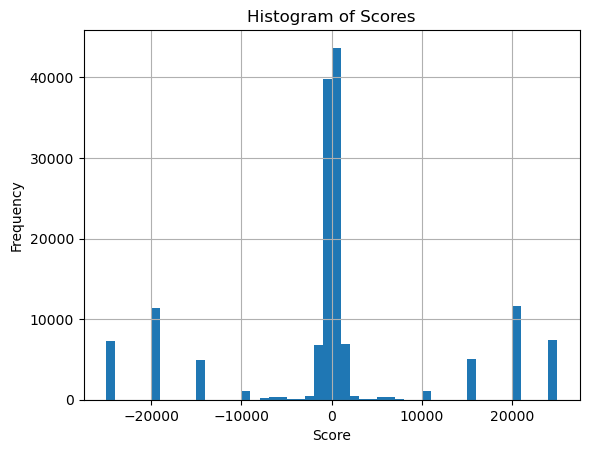

In [ ]:
plt.hist(y, bins=50)
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Now I can train the model on this combined dataset. Interstingly, the Dense layers architecture works much better on the new dataset, than CNN, so I will use 5 Dense layers:

In [ ]:
model = models.Sequential([
    layers.Input(shape=(8, 8, 17)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')

])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 95040184.0000 - mean_absolute_error: 5990.4609 - val_loss: 58593064.0000 - val_mean_absolute_error: 4410.4927
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 54333408.0000 - mean_absolute_error: 4257.0698 - val_loss: 53849196.0000 - val_mean_absolute_error: 4100.2778
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 41547040.0000 - mean_absolute_error: 3551.1792 - val_loss: 42583168.0000 - val_mean_absolute_error: 3524.3762
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 31312974.0000 - mean_absolute_error: 2970.9939 - val_loss: 38224960.0000 - val_mean_absolute_error: 3077.3381
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 23700740.0000 - mean_absolute_error: 2493.1497 - val_loss: 36493976.0000 - val_mean_absolute_error: 2944.0933
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 19495418.0000 - mean_absolute_error: 2221.9036 - val_loss: 35197428.0000

The performance metrics are now ddifferent, because of the new evaluations. In order to get an idea of model performance, I will plot a sorted evaluations graph, and see how far the predicted evaluations are from the real ones:

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


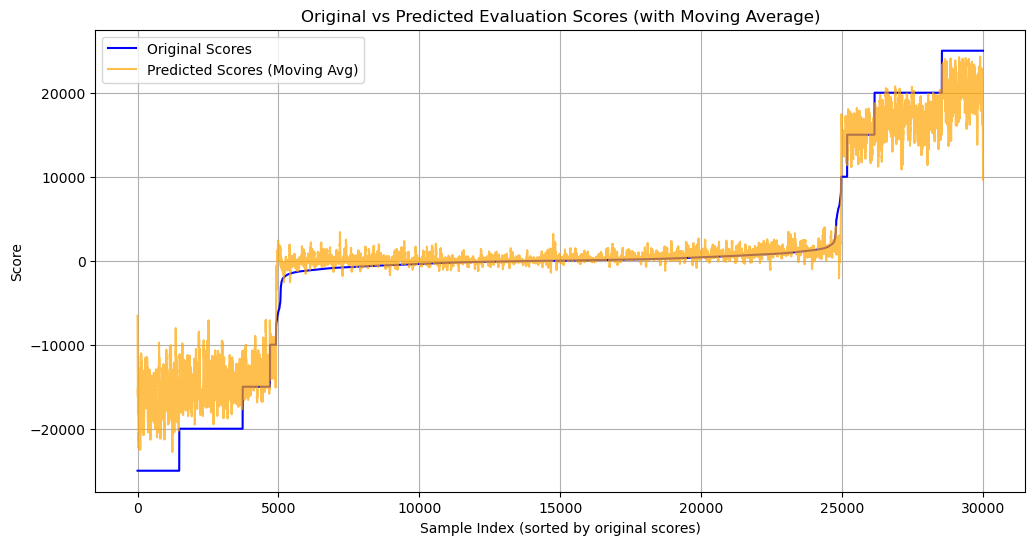

In [ ]:
# Get predictions
predictions = model.predict(X_val)
# Sort by original evaluation scores
sorted_indices = np.argsort(y_val)
sorted_original_scores = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(sorted_original_scores, label='Original Scores', color='blue')
# Apply moving average to smooth the predicted scores
window_size = 20
smoothed_predictions = np.convolve(sorted_predictions.flatten(), np.ones(window_size)/window_size, mode='same')
plt.plot(smoothed_predictions, label='Predicted Scores (Moving Avg)', color='orange', alpha=0.7)
plt.title('Original vs Predicted Evaluation Scores (with Moving Average)')
plt.xlabel('Sample Index (sorted by original scores)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

The above graph looks suspicious, because even if my model learned to distinguish between moves-to-mate positions, it looks like the middle range of scores are not predicted well. But there is even a bigger problem with this model. After trying this model in my chess engine I got the following situation in 3 consequtive games (you probably can figure out the issue):

![](board4.png)  __  ![](board5.png)  __  ![](board6.png)

The model learned that in order to checkmate, it needs to attack the opponent's king. But it didn't learn that the threat needs to be supported with other pieces to prevent the loss of the thretening piece. In all 3 games my chess engine attacks the Black king with the Queen, but the Queen is going to be captured in the next move.

The reason to this outcome is in the data. The moves-to-mate positions that I used (the tactics_eval.csv file) were probably taken from winning sequences and my model learned to rank them. However, the model didn't have any "bad" moves to compare to. For example in '#+1' position there can be 1 "good" move (checkmate), while all other moves lead to a losing position. The model didn't have the data to distinguish between those cases.

To solve that I decided to augment the moves-to-mate data. 

#### 4.5 Data augmentation and separate "checkmates" model

I've created a simple script, which goes through move-to-mate positions data, and for each - generates all legal moves in that position and evaluates them using the Stockfish engine, then adds all those new evaluations to the dataset. The idea is to add all existing variations for each position, so the model could learn how different moves change the evaluation, and how "bad" moves look like. Those really bad moves do not exist in the original datasets, but they are very important for training. 

Here is the script:

In [ ]:
import chess
import chess.engine

# Load the CSV file
df = pd.read_csv('positions/tactic_evals.csv')
# Convert the DataFrame to a numpy array
data = df.to_numpy()

# take only '#' 
data = data[np.char.startswith(data[:, 1].astype(str), '#')]

# Load the Stockfish chess engine
engine = chess.engine.SimpleEngine.popen_uci("/Users/alexber2024/Desktop/stockfish/stockfish-macos-m1-apple-silicon")

def mate_score(score):
    return '#+' + str(10000 - score) if score > 0 else '#-' + str(10000 + score)

def augment_moves_to_mate():
    with open("/positions/checkmates.csv", "a") as f:
        for row in data:
            fen = row[0]
            score = row[1]
            
            f.write(f"{fen},{score}\n")

            board = chess.Board(fen)
            
            if board.is_checkmate():
                continue

            for move in board.legal_moves:
                board.push(move)
                evaluation = engine.analyse(board, chess.engine.Limit(time=0.05))
                score = evaluation["score"].white().score(mate_score=10000)
                if abs(score) > 9996:  # Check for mate or near-mate
                    f.write(f"{board.fen()},{mate_score(score)}\n")
                else:
                    f.write(f"{board.fen()},{score}\n")
                board.pop()  # Undo the move


# Uncomment to run

# augment_moves_to_mate()

Next, I created a new dataset, only using the augmented data:

In [ ]:
# Load the CSV file
df = pd.read_csv('positions/checkmates.csv')
# Convert the DataFrame to a numpy array
data_checkmates = df.to_numpy()

# transform the moves-to-mate evaluations to scores
data_checkmates[:, 1] = np.array([transform_moves_to_mate_to_score(evaluation) for evaluation in data_checkmates[:, 1]])

#skip rows with evaluation bigger than 100000
data_checkmates = data_checkmates[data_checkmates[:, 1].astype(float) < 100000]

data_checkmates = data_checkmates[np.random.choice(data_checkmates.shape[0], 200000, replace=False)]

# shuffle the combined data
np.random.shuffle(data_checkmates)

X = data_checkmates[:, 0]  # Features (FEN strings)
y = data_checkmates[:, 1].astype(float)  # Labels (evaluations)

# Convert FEN strings to tensors
X_tensors = np.array([board_to_tensor(chess.Board(fen)) for fen in X])
# Reshape the tensors to match the input shape of the model
X_tensors = X_tensors.reshape(X_tensors.shape[0], 8, 8, 17)

# Split the data into training and validation sets
split_index = int(0.8 * len(X_tensors))
X_train = X_tensors[:split_index]
y_train = y[:split_index]
X_val = X_tensors[split_index:]
y_val = y[split_index:]

print(f'X shape: {X_tensors.shape}')
print(f'y shape: {y.shape}')

X shape: (200002, 8, 8, 17)
y shape: (200002,)


The distribution of scores in the augmented dataset:

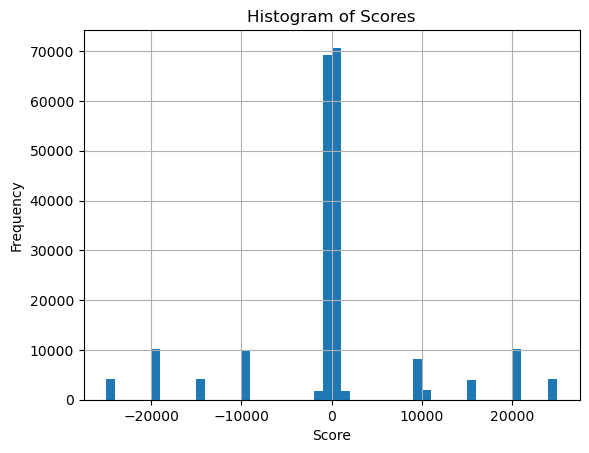

In [ ]:
plt.hist(y, bins=50)
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

I decided to create a separate model for checkmates (moves-to-mate) evaluations. The Dense layers worked much better for this dataset (I will discuss it in the Results section) Here is the implementation:

In [ ]:
model = models.Sequential([
    layers.Input(shape=(8, 8, 17)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')

])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

# Save the model
model.save('model_checkmates.h5')

Epoch 1/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 70463848.0000 - mean_absolute_error: 5295.2314 - val_loss: 52320624.0000 - val_mean_absolute_error: 4716.3911
Epoch 2/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 46609340.0000 - mean_absolute_error: 4415.4521 - val_loss: 39547500.0000 - val_mean_absolute_error: 3786.2441
Epoch 3/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 34841708.0000 - mean_absolute_error: 3592.3311 - val_loss: 41091780.0000 - val_mean_absolute_error: 4088.7046
Epoch 4/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 29167216.0000 - mean_absolute_error: 3168.3457 - val_loss: 33146324.0000 - val_mean_absolute_error: 3257.3811
Epoch 5/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 25462922.0000 - mean_absolute_error: 2882.9250 - val_loss: 30053000.0000 - val_mean_absolute_error: 3092.7900
Epoch 6/10
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 22767538.0000 - mean_absolute_error: 2624.6565 - val_loss: 30531774.0000

And here is the original vs predicted scores plot:

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step


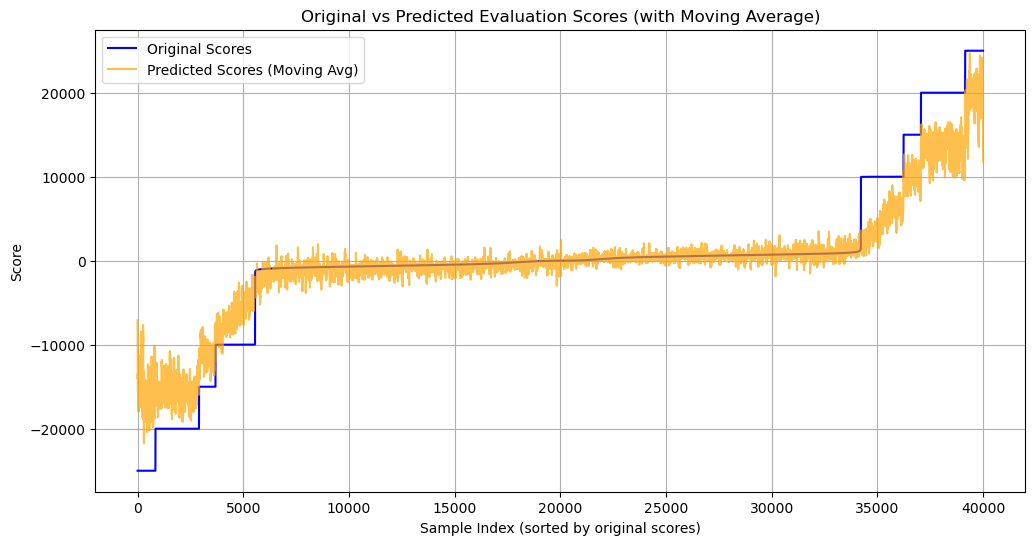

In [120]:
predictions = model.predict(X_val)
# Sort by original evaluation scores
sorted_indices = np.argsort(y_val)
sorted_original_scores = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(sorted_original_scores, label='Original Scores', color='blue')
# Apply moving average to smooth the predicted scores
window_size = 20  # You can adjust the window size for more/less smoothing
smoothed_predictions = np.convolve(sorted_predictions.flatten(), np.ones(window_size)/window_size, mode='same')
plt.plot(smoothed_predictions, label='Predicted Scores (Moving Avg)', color='orange', alpha=0.7)
plt.title('Original vs Predicted Evaluation Scores (with Moving Average)')
plt.xlabel('Sample Index (sorted by original scores)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

It looks much better! The model seems to have learned both the moves-to-mate positions and the positions with scores around 0 (which are mostly the augmented positions)

##### 4.6 Combining the two models

Now that I had two models, one for regular positions and another for augmented checkmate positions, I decided to combine them, and get a final model for my chess engine. The logic of combining is the following: if checkmate-model score is above 15000 use it as the evaluation, else use evaluation from score-model. And the rational is that checkmate-model can recognize a checkmate (or close to mate) positions, which the score-model cannot. But otherwise score-model can make good evaluations.

Here is the implementation of the combined model:

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
import tensorflow as tf

model_scores = load_model('model_scores.h5')
model_checkmates = load_model('model_checkmates.h5')

# Create a new model that combines the two models in parallel and output the max of the two outputs
input_layer = layers.Input(shape=(8, 8, 17))

output_scores = model_scores(input_layer)
output_checkmates = model_checkmates(input_layer)
# Use a Lambda layer to select the output with higher confidence (lower absolute value means less confidence for checkmates)
def select_by_confidence(inputs):
    score, checkmate = inputs
    # If checkmate output is far from zero (e.g. |checkmate| > 9000), trust checkmate model, else trust score model
    # You can tune the threshold as needed
    threshold = 15000.0
    use_checkmate = tf.abs(checkmate) > threshold
    return tf.where(use_checkmate, checkmate, score)

combined_output = layers.Lambda(select_by_confidence)([output_scores, output_checkmates])

combined_model = models.Model(inputs=input_layer, outputs=combined_output)

combined_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=[tf.keras.metrics.MeanAbsoluteError()])

I will end this section with a game of my chess engine (White) based on the combined model. My engine wins with a checkmate:

![](game11.gif)

### 5. Results and Discussion

In this section I will iterate on the results, compare different models I used, and discuss what worked well and what didn't.

I can say that I achieved the goal of this project. I've created a simple chess engine that is based purely on a Deep Learning model. Below is the script for the chess engine. There is also a function to play a game against another engine and outputs the moves.

In [20]:
import chess.engine
import random

class SimpleChessEngine:
    def __init__(self, model):
        self.model = model

    def evaluate_position(self, fen):
        board = chess.Board(fen)
        tensor = board_to_tensor(board)
        tensor = np.expand_dims(tensor, axis=0)

        evaluation = self.model.predict(tensor, verbose=0)
        return evaluation[0][0]

    def get_best_move(self, fen, player):
        board = chess.Board(fen)
        best_move = None
        best_evaluation = float('-inf') if player == chess.WHITE else float('inf')

        for move in board.legal_moves:
            board.push(move)
            evaluation = self.evaluate_position(board.fen())

            board.pop()

            if evaluation > best_evaluation:
                best_evaluation = evaluation
                best_move = move

        return best_move
    
def play_game(my_color, my_engine, opponent_engine=None):
    board = chess.Board()
    max_moves = 80
    while not board.is_game_over() and len(board.move_stack) < max_moves:
        if board.turn == my_color:
            move = my_engine.get_best_move(board.fen(), my_color)
        else:
            if (opponent_engine is not None and random.random() < 0.5):
                move = opponent_engine.play(board, chess.engine.Limit(time=0.001)).move
            else:
                move = random.choice(list(board.legal_moves))

        board.push(move)

    print("Result:", board.result())
    print("Moves history:")
    for move in board.move_stack:
        print(str(move))



my_engine = SimpleChessEngine(combined_model)

# load Stockfish engine
stockfish_engine = chess.engine.SimpleEngine.popen_uci("/Users/alexber2024/Desktop/stockfish/stockfish-macos-m1-apple-silicon")
stockfish_engine.configure({"Skill Level": 1})

play_game(chess.WHITE, my_engine, stockfish_engine)

Result: *
Moves history:
d2d4
c7c6
b1c3
d7d6
a2a4
g7g6
h2h3
b8d7
g1f3
a7a5
d1d3
a8b8
c1e3
h7h6
e1c1
d7f6
f3d2
c8f5
g2g4
f5d3
g4g5
f6d5
c3d5
f7f5
d5f4
d8c7
f4d3
e7e5
d4e5
d6e5
d3e5
c6c5
e3c5
c7c5
b2b4
c5b4
c2c3
b4b2
c1b2
b7b5
b2c1
f8d6
d2e4
g8f6
e4d6
e8d8
d1d2
f5f4
g5f6
b5b4
e5g6
b4c3
g6h8
f4f3
d2c2
b8b3
h8f7
d8d7
d6b5
d7e6
f7h6
b3a3
b5c3
a3a4
e2f3
a4d4
h6g4
d4c4
f1g2
c4e4
c1d2
e4d4
d2e3
e6d6
h1b1
d4b4
b1b4
d6c7
b4b8
c7b8


### 6. Conclusion